In [41]:
import logging
import warnings

import numpy as np
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import json
import urllib.request

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.preprocessing.utils import *
from typing import Dict
# from typing import Dict, List
import sqlite3 as sqlite


In [42]:
# fdir = '/data/proj/scATAC/samples/'                                                            

# files = [os.path.join(fdir, x, f'{x}_GA.loom') for x in ['10XSF12017', '10XSF11964', '10XSF11956', '10XSF11949', '10XSF11612', '10XSF11331', '10XSF11215']]

In [ ]:
# for f in files:
#     with loompy.connect(f, 'r+') as ds:
#         ds.ca.Targetnumcells = np.array([5000]* ds.shape[1])
#         ds.ca.Pcrcycles = np.array([0]*ds.shape[1])
#         ds.ca.DoubletFinderFlag = ds.ca.DoubletFinderFlag.astype(np.int64)

In [45]:
summary = {'reference_assembly': 'hg38'}
genome_size = None
# Get Chromosome sizes
if genome_size == None:
    chrom_size = get_chrom_sizes(summary['reference_assembly'])    
else:
    chrom_size = {}
    with open(genome_size) as f:
        for line in f:
            x = line.split()
            chrom_size[x[0]] = int(x[1])

11:47:36 INFO     Genome not recognized


In [46]:
chrom_size

In [43]:
f = '/data/proj/scATAC/chromograph/Kriegstein_20200618/All/All.loom'

with loompy.connect(f) as ds:
    print(ds.ca.keys())

['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Finalconc', 'GA_colsum', 'Id', 'Idxset', 'Inputmrna', 'Label', 'Method', 'Molarity', 'NBins', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UMAP', 'UMAP3D', 'barcode', 'blacklist_region_fragments', 'cell_id', 'chimeric', 'duplicate', 'enhancer_region_fragments', 'is__cell_barcode', 'lowmapq', 'mitochondria

In [3]:
# Description etc to be added

import numpy as np
import glob
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import json
import urllib.request
import logging
import pickle
import importlib

sys.path.append('/home/camiel/chromograph/')
from chromograph.pipeline import config
from chromograph.preprocessing.utils import *
from chromograph.features.feature_count import *
from chromograph.preprocessing.doublet_finder import doublet_finder

class Chromgen:
    def __init__(self) -> None:
        """
        Generate a binned loom file from scATAC-seq data
        
        Args:
            steps                    Which steps to include in the analysis

        Remarks:
            # All parameters are obtained from the config object, which comes from the default config
            # and can be overridden by the config in the current punchcard
        """
        self.config = config.load_config()
        pybedtools.helpers.set_bedtools_path(self.config.paths.bedtools)
        logging.info("Chromgen initialised")
    
    def fit(self, indir: str, input_type: str = 'cellranger', bsize: int = 5000, outdir: str = None, genome_size: str = None, blacklist: str = None) -> None:
        ''''
        Create a .loom file from 10X Genomics cellranger output with reads binned
        Args:
            indir (str):	     path to the cellranger output folder (the one that contains 'outs')
            input_type (str):    either 'cellranger' when running from cellranger output or 'bam'. If 'bam' make sure to add a summary.json file in the same folder.
            bsize (int):	     size of the bins (defaults to 5000/5kb)
            outdir (str):	     output folder wher the new loom file should be saved (default to indir)
            genome_size (str):	 path to file containing chromosome sizes, usually derived from encode (i.e. 'hg19.chrom.sizes.tsv')
            blacklist (str):	 path to bedfile containing blacklisted region (i.e. 'blacklist_hg19.bed')
        Returns:
            path (str):		Full path to the created loom file.
        Remarks:
            The resulting file will be named ``{sampleID}.loom``, where the sampleID is the one given by cellranger.
        '''
        logging.info("Binning reads from {} into {} kb bins".format(indir.split('/')[-1], (bsize/1000)))
        
        if input_type == 'cellranger':
            logging.info("Reading from {}".format(indir))
            fb = indir + '/outs/singlecell.csv'
            ff = indir + '/outs/fragments.tsv.gz'
            fs = indir + '/outs/summary.json'
        elif input_type == 'bam':
            logging.info("Reading from {}".format(indir))
            ff = glob.glob(indir + '/*.bam')[0]
            fs = indir + '/summary.json'
            
        sample = indir.split('/')[-1]

        if len(sample.split('_')) > 2:
            sample = '_'.join(sample.split('_')[:2])

        if not os.path.isdir(outdir):
            os.mkdir(outdir)
   
        logging.info(f'Reading summary for {sample} from Cellranger output {fs}')
        with open(fs, "r") as f:
            summary = json.load(f)

            for k,v in summary.items():
                summary[k] = str(v)
        summary['bin_size'] = bsize
        summary['level'] = self.config.params.level
        
        if input_type == 'cellranger':
            logging.info(f'Reading metadata from cellranger output')
            barcodes = np.genfromtxt(fb, delimiter=',', skip_header=2,
                                     dtype={'names':('barcode','total','duplicate','chimeric','unmapped','lowmapq','mitochondrial','passed_filters','cell_id','is__cell_barcode',
                                                       'TSS_fragments','DNase_sensitive_region_fragments','enhancer_region_fragments','promoter_region_fragments','on_target_fragments',
                                                       'blacklist_region_fragments','peak_region_fragments','peak_region_cutsites'),
                                             'formats':('U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8')})

            ## Transfer metadata to dict format
            meta = {}
            passed = (barcodes['is__cell_barcode'] == 1) & (barcodes['passed_filters'] > self.config.params.level) & (barcodes['passed_filters'] < 100000)
            for key in barcodes.dtype.names:
                meta[key] = barcodes[key][passed]
            meta['CellID'] = [f'{sample}:{x}' for x in meta['barcode']]
            
        elif input_type == 'bam':
            bam = pysam.AlignmentFile(ff, 'rb')
            bam_it = bam.fetch(until_eof = True)

            meta = {}
            meta['barcode'] = np.unique(np.array([b.get_tag('CB') for b in bam_it]))
            meta['CellID'] = [f'{sample}:{x}' for x in meta['barcode']]
            
    
        ## Retrieve sample metadata from SangerDB
        logging.info(f'Retrieve metadata from {[self.config.paths.metadata, sample]}')
        m =  load_sample_metadata(self.config.paths.metadata, sample)
        for k,v in m.items():
            meta[k] = np.array([v] * len(meta['barcode']))


        logging.info("Total of {} valid cells".format(len(meta['barcode'])))
        
        logging.info("Ref. assembly {}".format(summary['reference_assembly']))

        # Get Chromosome sizes
        if genome_size == None:
            chrom_size = get_chrom_sizes(summary['reference_assembly'])    
        else:
            chrom_size = {}
            with open(genome_size) as f:
                for line in f:
                    x = line.split()
                    chrom_size[x[0]] = int(x[1])

        ## Read Fragments and generate size bins
        logging.info("Read fragments into dict")
        frag_dict = read_fragments(ff)
        
        ## Split fragments to seperate files for fast indexing
        logging.info(f"Saving fragments to separate folder for fast indexing")
        fdir = os.path.join(outdir, 'fragments')
        if not os.path.isdir(fdir):
            os.mkdir(fdir)

        ## Save fragments to folder
        i = 0
        for x in meta['barcode']:
            f = os.path.join(fdir, f'{x}.tsv.gz')
            frags = BedTool(frag_dict[x]).saveas(f)
            i += 1
            if i%1000 == 0:
                logging.info(f'Finished separating fragments for {i} cells')
                
        del frags
        
        logging.info("Generate {} bins based on provided chromosome sizes".format(str(int(bsize/1000)) + ' kb'))
        chrom_bins = generate_bins(chrom_size, bsize)

        ## Count fragments inside bins
        logging.info("Count fragments overlapping with bins")
        Count_dict = count_bins(frag_dict, meta['barcode'], bsize)
        logging.info("Finished counting fragments")

        logging.info("Loading blacklist")
        # Load Blacklist
        if blacklist == None:
            blacklist = get_blacklist(summary['reference_assembly'])    

        logging.info("Remove bins that overlap with the ENCODE blacklist")
        black_list = BedTool(blacklist)
        bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
        intervals = BedTool(bins)
        cleaned = intervals.subtract(black_list, A=True)

        keep = [(row['chrom'], int(row['start']), int(row['end'])) for row in cleaned.sort()] # Sort the bins to make downstream alignment with features easier
        retain = [chrom_bins[x] for x in keep]
        clean_bin = [bins[x] for x in retain]
        
        logging.info("Number of bins after cleaning: {}".format(len(clean_bin)))

        #####
        # Construct loom file
        #####
        
        # Create sparse matrix
        
        logging.info("Generating Sparse matrix")
        col = []
        row = []
        v = []

        cix = 0
        for cell in meta['barcode']:

            for key in (Count_dict[cell]):
                col.append(cix)
                row.append(chrom_bins[key])
                v.append(int(Count_dict[cell][key]))
            cix+=1
        matrix = sparse.coo_matrix((v, (row,col)), shape=(len(chrom_bins.keys()), len(meta['barcode'])))

        ## Save a smaller section of the summary
        keys = ['cellranger-atac_version', 'reference_assembly', 'reference_assembly_accession', 'reference_assembly_fasta_url', 'reference_organism', 'reference_version', 'bin_size']
        small_summary = {k: summary[k] for k in keys}
        
        ## We retain only the bins that have no overlap with the ENCODE blacklist
        cleaned_matrix = matrix.tocsc()[retain,:]
        logging.info("Identified {} positive bins in {} cells before filtering blacklist".format(len(v), len(meta['barcode'])))
        logging.info("Identified {} positive bins in {} cells after filtering blacklist".format(len(cleaned_matrix.nonzero()[0]), len(meta['barcode'])))

        ## Create row attributes
        chrom = [x[0] for x in clean_bin]
        start = [x[1] for x in clean_bin]
        end = [x[2] for x in clean_bin]

        row_attrs = {'loc': np.array([f'{c}:{s}-{e}' for c,s,e in zip(chrom, start, end)]), 
                     'chrom': np.array(chrom), 'start': np.array(start), 'end': np.array(end)}

        ## Create loomfile
        logging.info("Constructing loomfile")
        sampleid = sample + '_' + str(int(bsize/1000)) + 'kb'
        floom = os.path.join(outdir, sampleid + '.loom')

        loompy.create(filename=floom, 
                      layers=cleaned_matrix, 
                      row_attrs=row_attrs, 
                      col_attrs=meta,
                      file_attrs=small_summary)
        self.loom = floom
        logging.info("Loom bin file saved as {}".format(floom))
        
        ## Cleanup
        del black_list, Count_dict, chrom_bins, chrom_size, intervals, cleaned, keep, retain, clean_bin, matrix, cleaned_matrix, col, row, v
        
        ## Doublet detection
        logging.info(f'Detecting doublets in loom file')

        with loompy.connect(self.loom, 'r+') as ds:
            ds.ca['DoubletFinderScore'], ds.ca['DoubletFinderFlag'] = doublet_finder(ds, proportion_artificial=.2, qc_dir = outdir, max_th=0.6)
            meta['DoubletFinderScore'] = ds.ca['DoubletFinderScore']
            meta['DoubletFinderFlag'] = ds.ca['DoubletFinderFlag']

        ######
        ## Generate Gene Accessibility Scores
        ######
        
        logging.info('## Start generating Gene Acessibility Scores ##')
        fragments = BedTool(ff)
        
        ## Saving fragments in cells
        
        logging.info('Load Genomic regions from reference')
        gb = BedTool(os.path.join(chromograph.__path__[0], 'references/GRCh38_genes_2kbprom.bed')).saveas()
        
        logging.info('Intersecting fragments with Genomic regions')
        inter = gb.intersect(fragments, wa=True, wb=True)
        
        logging.info('Count Gene body overlapping reads per barcode')
        Count_dict = Count_genes(meta['barcode'], inter)
        
        logging.info('Reorder data and generate sparse matrix')
        r_dict = {k: [] for k in ['Accession', 'Gene', 'loc', 'BPs']}
        for x in gb:
            r_dict['Accession'].append(x.attrs['gene_id'])
            r_dict['Gene'].append(x.attrs['gene_name'])
            r_dict['loc'].append(f'{x[0]}:{x[3]}-{x[4]}')
            r_dict['BPs'].append(int(abs(int(x[3])-int(x[4]))))
        
        g_dict = {k: v for v,k in enumerate(r_dict['Accession'])}
        
        ## Create sparse matrix
        col = []
        row = []
        v = []

        cix = 0
        for cell in meta['barcode']:

            for key in (Count_dict[cell]):
                col.append(cix)
                row.append(g_dict[key])
                v.append(float(Count_dict[cell][key]))
            cix+=1

        matrix = sparse.coo_matrix((v, (row,col)), shape=(len(g_dict.keys()), len(meta['barcode']))).tocsr()
        logging.info(f'Shape matrix: {matrix.shape}. Number of elements: {matrix.nnz}')
        
        # Do some cleanup
        pybedtools.helpers.cleanup()
        del col, row, v, Count_dict, barcodes, bins, blacklist, frag_dict, fragments, g_dict, gb, inter, summary

        ## Create loomfile
        logging.info("Constructing loomfile")
        floom = os.path.join(outdir, sample + '_GA.loom')

        loompy.create(filename=floom, 
                      layers=matrix, 
                      row_attrs=r_dict, 
                      col_attrs=meta,
                      file_attrs=small_summary)
        self.gloom = floom
        
        logging.info("Loom gene file saved as {}".format(floom))



/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import pysam

f = glob.glob('/data/proj/tumor/Kriegstein/atac_bams/SF11215/*.bam')[0]
sample = f.split('/')[-2]

bam = pysam.AlignmentFile(f, 'rb')
bam_it = bam.fetch(until_eof = True)

meta = {}
meta['barcode'] = np.unique(np.array([b.get_tag('CB') for b in bam_it]))
meta['CellID'] = [f'{sample}:{x}' for x in meta['barcode']]

In [23]:
i = 0
bam = pysam.AlignmentFile(f, 'rb')
bam_it = bam.fetch(until_eof = True)
for r in bam_it:
    print(r.mate())
    i += 1
    if i%5==0:
        break

AttributeError: 'pysam.libcalignedsegment.AlignedSegment' object has no attribute 'mate'

In [21]:
?bam.fetch

Docstring:
AlignmentFile.fetch(self, contig=None, start=None, stop=None, region=None, tid=None, until_eof=False, multiple_iterators=False, reference=None, end=None)
fetch reads aligned in a :term:`region`.

        See :meth:`~pysam.HTSFile.parse_region` for more information
        on how genomic regions can be specified. :term:`reference` and
        `end` are also accepted for backward compatiblity as synonyms
        for :term:`contig` and `stop`, respectively.

        Without a `contig` or `region` all mapped reads in the file
        will be fetched. The reads will be returned ordered by reference
        sequence, which will not necessarily be the order within the
        file. This mode of iteration still requires an index. If there is
        no index, use `until_eof=True`.

        If only `contig` is set, all reads aligned to `contig`
        will be fetched.

        A :term:`SAM` file does not allow random access. If `region`
        or `contig` are given, an exception is

In [ ]:
def read_bam(file):
    '''
    '''
    bam = pysam.AlignmentFile(file, 'rb')
    bam_it = bam.fetch(until_eof = True)

    frag_dict = collections.OrderedDict()
    new = 0
    add = 0
    for read in bam_it:
        b = read.get_tag('CB')

        if b not in frag_dict:
            frag_dict[b] = [[r[0].decode(), int(r[1].decode()), int(r[2].decode())]]
            new += 1
        else:
            frag_dict[b].append([r[0].decode(), int(r[1].decode()), int(r[2].decode())])
            add += 1

    logging.info('barcodes: {}   fragments: {}'.format(new, (new+add)))
    return frag_dict;

In [2]:
def load_sample_metadata(path: str, sample_id: str) -> Dict[str, str]:
    if not os.path.exists(path):
        raise ValueError(f"Samples metadata file '{path}' not found.")
    if path.endswith(".db"):
        # sqlite3
        with sqlite.connect(path) as db:
            cursor = db.cursor()
            cursor.execute("SELECT * FROM sample WHERE name = ?", (sample_id,))
            keys = [x[0].capitalize() for x in cursor.description]
            vals = cursor.fetchone()
            if vals is not None:
                return dict(zip(keys, vals))
            raise ValueError(f"SampleID '{sample_id}' was not found in the samples database.")
    else:
        result = {}
        with open(path) as f:
            headers = [x.lower() for x in f.readline()[:-1].split("\t")]
            if "sampleid" not in headers and 'name' not in headers:
                raise ValueError("Required column 'SampleID' or 'Name' not found in sample metadata file")
            if "sampleid" in headers:
                sample_metadata_key_idx = headers.index("sampleid")
            else:
                sample_metadata_key_idx = headers.index("name")
            sample_found = False
            for line in f:
                items = line[:-1].split("\t")
                if len(items) > sample_metadata_key_idx and items[sample_metadata_key_idx] == sample_id:
                    for i, item in enumerate(items):
                        result[headers[i]] = item
                    sample_found = True
        if not sample_found:
            raise ValueError(f"SampleID '{sample_id}' not found in sample metadata file")
        return result

In [2]:
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [10]:
sampleid = 'MUV16'
indir = f"/data/proj/chromium/DIPG_scATAC/{sampleid}"

sample = indir.split('/')[-1]
bsize = 5000
genome_size = None
f_blacklist = None
level = 5000
outdir = '/data/proj/scATAC/chromograph/tmp/{}'.format(indir.split('/')[-1])

In [11]:
fb = indir + '/outs/singlecell.csv'
ff = indir + '/outs/fragments.tsv.gz'
fs = indir + '/outs/summary.json'

if not os.path.isdir(outdir):
    os.mkdir(outdir)

with open(fs, "r") as f:
    summary = json.load(f)
    
    for k,v in summary.items():
        summary[k] = str(v)

summary['bin_size'] = bsize
summary['level'] = level

barcodes = np.genfromtxt(fb, delimiter=',', skip_header=2,
                         dtype={'names':('barcode','total','duplicate','chimeric','unmapped','lowmapq','mitochondrial','passed_filters','cell_id','is__cell_barcode',
                                           'TSS_fragments','DNase_sensitive_region_fragments','enhancer_region_fragments','promoter_region_fragments','on_target_fragments',
                                           'blacklist_region_fragments','peak_region_fragments','peak_region_cutsites'),
                                 'formats':('U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'U18', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8', 'i8')})

In [14]:
## Transfer metadata to dict format
meta = {}
for key in barcodes.dtype.names:
    passed = np.logical_and(barcodes['is__cell_barcode'] == 1, barcodes['passed_filters'] > level)
    meta[key] = barcodes[key][passed]
print(np.sum(passed))

1323


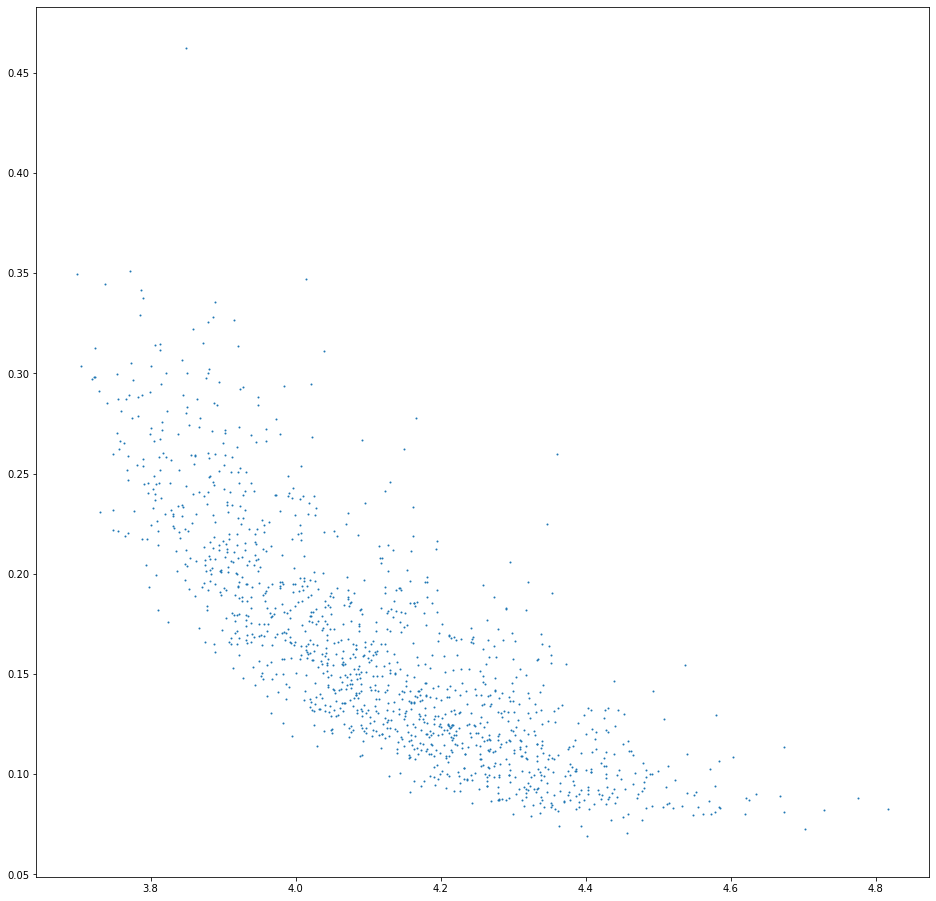

In [13]:
plt.figure(figsize=(16,16))
plt.scatter(np.log10(meta['passed_filters']), meta['promoter_region_fragments']/meta['passed_filters'], s=1)

In [5]:
## Transfer metadata to dict format
meta = {}
for key in barcodes.dtype.names:
    passed = np.logical_and(barcodes['is__cell_barcode'] == 1, barcodes['passed_filters'] > level)
    meta[key] = barcodes[key][passed]
    
## Retrieve sample metadata from SangerDB
m =  load_sample_metadata('/nfs/sanger-data/10X/DB/sqlite3_chromium.db', sample)
for k,v in m.items():
    meta[k] = np.array([v] * len(meta['barcode']))
    
logging.info("Total of {} valid cells".format(len(meta['barcode'])))

# Get Chromosome sizes
if genome_size == None:
    chrom_size = get_chrom_sizes(summary['reference_assembly'])    
else:
    chrom_size = {}
    with open(genome_size) as f:
        for line in f:
            x = line.split()
            chrom_size[x[0]] = int(x[1])

11:35:05 INFO     Total of 9508 valid cells
11:35:05 INFO     Loaded chromosome sizes for GRCh38


In [6]:
from chromograph.pipeline import config

config = config.load_config()
config.params

Config(batch_keys=[], bin_size=5000, clusterer='louvain', cov=1.75, factorization='PCA', k=25, k_pooling=10, max_fraction_MT_genes=0.05, min_fraction_good_cells=0.4, min_frags=5000, n_factors=50, nn_space='auto', passedQC=False, skip_metadata=False, skip_missing_samples=False)

In [10]:
bsize = f'{int(config.params.bin_size/1000)}kb'
samples = ['10X232_1', '10X232_2']
files = [os.path.join(config.paths.samples, sample, sample + f"_{bsize}.loom") for sample in samples]
print(files)

['/data/proj/scATAC/samples/10X232_1/10X232_1_5kb.loom', '/data/proj/scATAC/samples/10X232_2/10X232_2_5kb.loom']


In [40]:
## Read Fragments and generate size bins
logging.info("Read fragments into dict")
frag_dict = read_fragments(ff)

09:39:05 INFO     Read fragments into dict


KeyboardInterrupt: 

In [40]:
logging.info(f"Saving fragments to separate folder for fast indexing")

fdir = os.path.join(outdir, 'fragments')

if not os.path.isdir(fdir):
    os.mkdir(fdir)

i = 0
for x in meta['barcode']:
    f = os.path.join(fdir, f'{x}.tsv.gz')
    frags = BedTool(frag_dict[x]).saveas(f)
    i += 1
    if i%1000 == 0:
        logging.info(f'Finished separating fragments for {i} cells')
# meta['fragments'] = [np.array(frag_dict[k]) for k in meta['barcode']]

# logging.info("Saving fragments to dict")
# fpick = outdir + '/' + sampleid + '_frags.pkl'
# pickle.dump(frag_dict, fpick)

15:43:34 INFO     Saving fragments to separate folder for fast indexing
15:53:44 INFO     Finished separating fragments for 1000 cells
16:04:38 INFO     Finished separating fragments for 2000 cells
16:14:53 INFO     Finished separating fragments for 3000 cells
16:25:00 INFO     Finished separating fragments for 4000 cells
16:34:55 INFO     Finished separating fragments for 5000 cells


In [6]:
logging.info("Generate {} bins based on provided chromosome sizes".format(str(int(bsize/1000)) + ' kb'))
chrom_bins = generate_bins(chrom_size, bsize=bsize)

11:48:13 INFO     Read fragments into dict


KeyboardInterrupt: 

## Count fragments inside bins based on cell barcodes

In [7]:
logging.info(f"Counting fragments in bins")
Count_dict = count_bins(frag_dict, meta['barcode'], summary['bin_size'])

11:02:52 INFO     Counting fragments in bins
11:04:28 INFO     Finished counting 500 cells
11:05:54 INFO     Finished counting 1000 cells
11:07:32 INFO     Finished counting 1500 cells
11:09:10 INFO     Finished counting 2000 cells
11:10:36 INFO     Finished counting 2500 cells
11:12:14 INFO     Finished counting 3000 cells
11:13:38 INFO     Finished counting 3500 cells
11:15:09 INFO     Finished counting 4000 cells
11:16:31 INFO     Finished counting 4500 cells
11:17:56 INFO     Finished counting 5000 cells


## Remove blacklisted regions

In [ ]:
## Download Blacklist

# Load Blacklist
if f_blacklist == None:
    f_blacklist = get_blacklist(summary['reference_assembly'])    

blacklist = BedTool(f_blacklist)
bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
intervals = pybedtools.BedTool(bins)
cleaned = intervals.subtract(blacklist, A=True)

keep = [(row['chrom'], int(row['start']), int(row['end'])) for row in cleaned]
retain = [chrom_bins[x] for x in keep]
clean_bin = [bins[x] for x in retain]

print('Number of bins after cleaning: {}'.format(len(clean_bin)))

## Construct loom file

In [ ]:
## Create sparse matrix
col = []
row = []
v = []

cix = 0
for cell in meta['barcode']:
    
    for key in (Count_dict[cell]):
        col.append(cix)
        row.append(chrom_bins[key])
        v.append(Count_dict[cell][key])
    cix+=1

matrix = sparse.coo_matrix((v, (row,col)), shape=(len(chrom_bins.keys()), len(meta['barcode'])))

## Save a smaller section of the summary
keys = ['cellranger-atac_version', 'reference_assembly', 'reference_assembly_accession', 'reference_assembly_fasta_url', 'reference_organism', 'reference_version', 'bin_size']
small_summary = {k: summary[k] for k in keys}

## We retain only the bins that have no overlap with the ENCODE blacklist
cleaned_matrix = matrix.tocsr()[retain,:]
print('Identified {} positive bins in {} cells before filtering blacklist'.format(len(v), len(meta['barcode'])))
print('Identified {} positive bins in {} cells after filtering blacklist'.format(len(cleaned_matrix.nonzero()[0]), len(meta['barcode'])))

## Create row attributes
chrom = [x[0] for x in clean_bin]
start = [x[1] for x in clean_bin]
end = [x[2] for x in clean_bin]

row_attrs = {'chrom': chrom, 'start': start, 'end': end}

In [ ]:
## Create loomfile
sampleid = indir.split('/')[-1] + '_' + str(int(bsize/1000)) + 'kb'
f = outdir + '/' + sampleid + '.loom'

loompy.create(filename=f, 
              layers=cleaned_matrix, 
              row_attrs=row_attrs, 
              col_attrs=meta,
              file_attrs=small_summary)

In [ ]:
ds = loompy.connect(f)
# ds.close()

(0, 1)

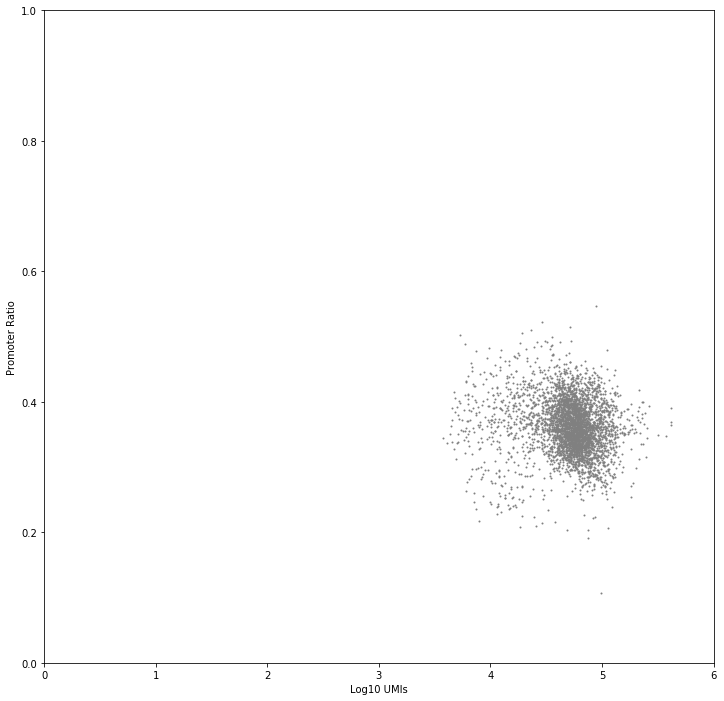

In [15]:
UMIs = np.log10(ds.ca['passed_filters'] + 1)
Prom_rat = (ds.ca['promoter_region_fragments'] + 1) / (ds.ca['passed_filters'] + 1)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(UMIs, Prom_rat, s=1, c='grey')
ax.set_xlabel('Log10 UMIs')
ax.set_ylabel('Promoter Ratio')
ax.set_xlim((0,6))
ax.set_ylim((0,1))

In [25]:
nnz = ds.map([np.count_nonzero], axis=1)[0]
nnz

array([2265.,  843.,  522., ...,  540.,  681.,  645.])